In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# Ignore warnings
import warnings
warnings.simplefilter('ignore')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e4/sample_submission.csv
/kaggle/input/playground-series-s5e4/train.csv
/kaggle/input/playground-series-s5e4/test.csv


# Import statements

In [2]:

# Feature Engineering
from sklearn.preprocessing import StandardScaler
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# ML Models
from xgboost import XGBRegressor # can use GPUs while sklearn can't 

# Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error # RMSE = mse**0.5

# Load data and split into training and validation sets

In [3]:
fulltrain_df = pd.read_csv("/kaggle/input/playground-series-s5e4/train.csv")
fulltest_df = pd.read_csv("/kaggle/input/playground-series-s5e4/test.csv")
target_column = 'Listening_Time_minutes' # y variable

# Explore data

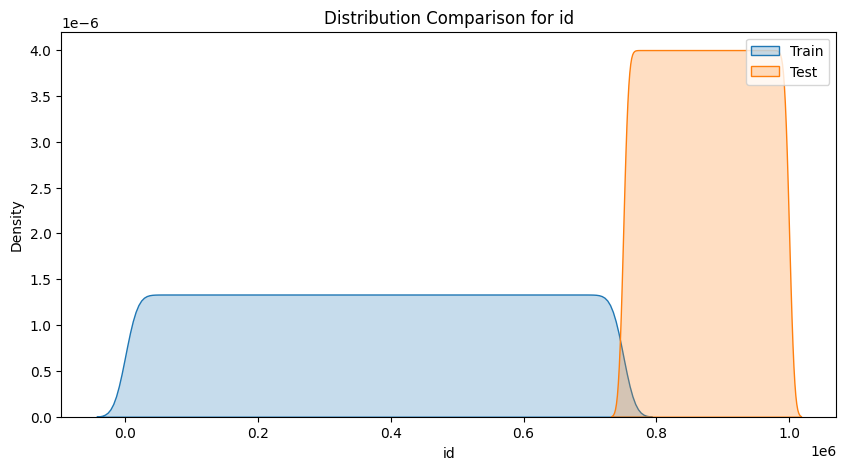

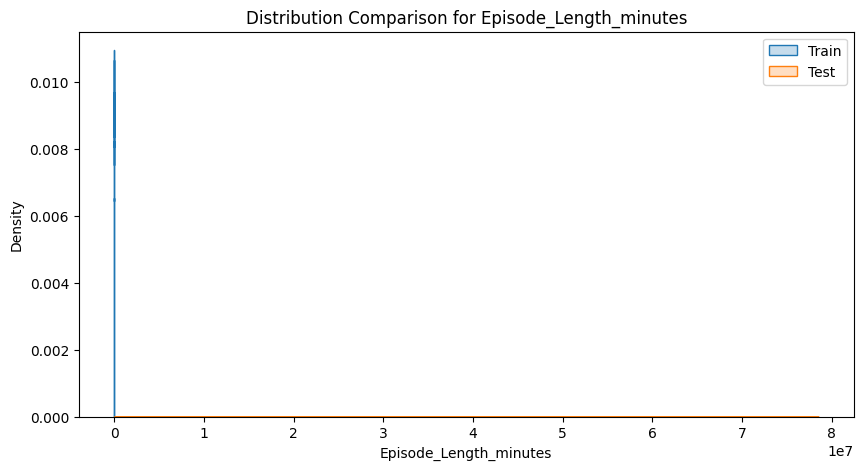

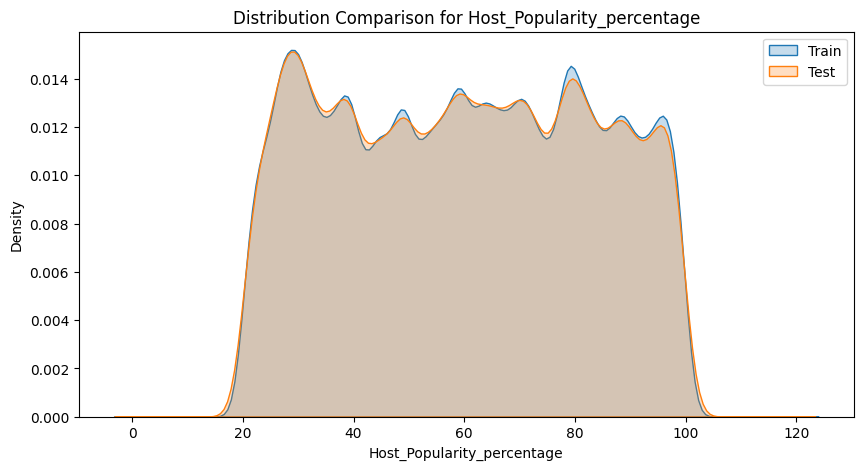

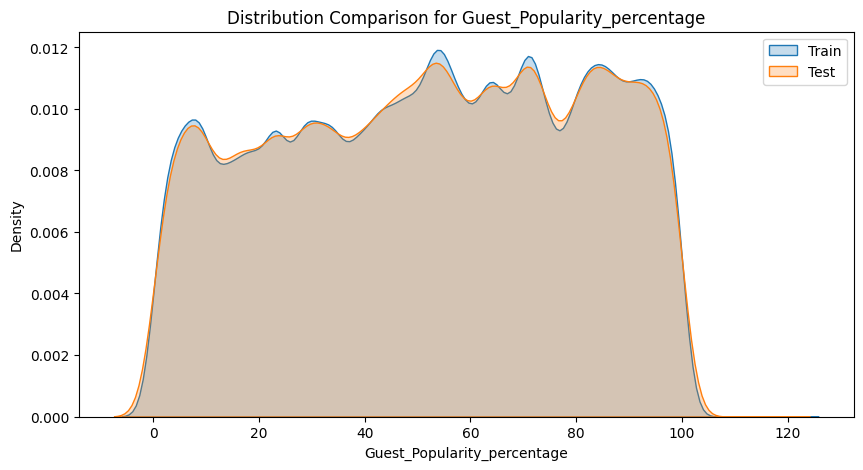

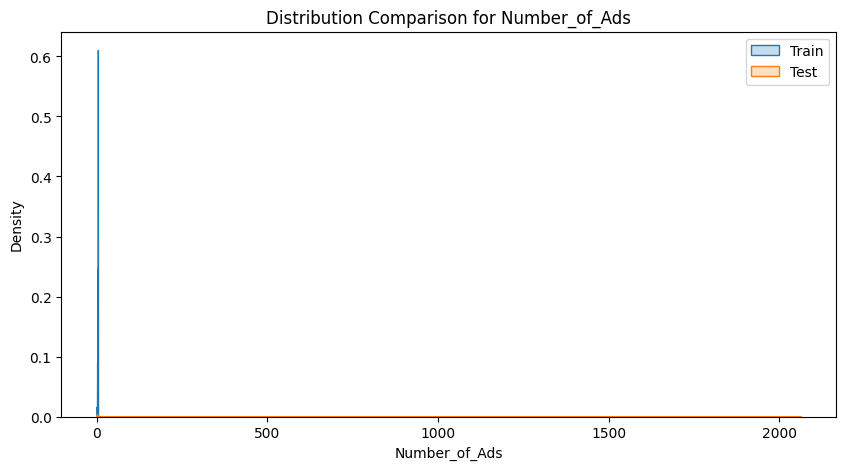

In [4]:
def check_numerical_distribution(train, test):
    # Use test df to get numerical features since it doesn't have the target variable and we want to avoid that
    numerical_features = test.select_dtypes(include=['float64','int64']).columns.to_list()

    for col in numerical_features:
        plt.figure(figsize=(10, 5))
        sns.kdeplot(train[col], label='Train', fill=True)
        sns.kdeplot(test[col], label='Test', fill=True)
        plt.title(f'Distribution Comparison for {col}')
        plt.legend()
        plt.show()

# fulltrain_df.info() # there are sum NULL (missing) values and all seem to be numerical type. Columns - [Episode_Length_minutes,Guest_Popularity_percentage]
# fulltrain_df.duplicated().any() # no duplicates
check_numerical_distribution(fulltrain_df, fulltest_df)

# Feature Engineer

id
Episode_Length_minutes
Host_Popularity_percentage
Guest_Popularity_percentage
Number_of_Ads
id
Episode_Length_minutes
Host_Popularity_percentage
Guest_Popularity_percentage
Number_of_Ads


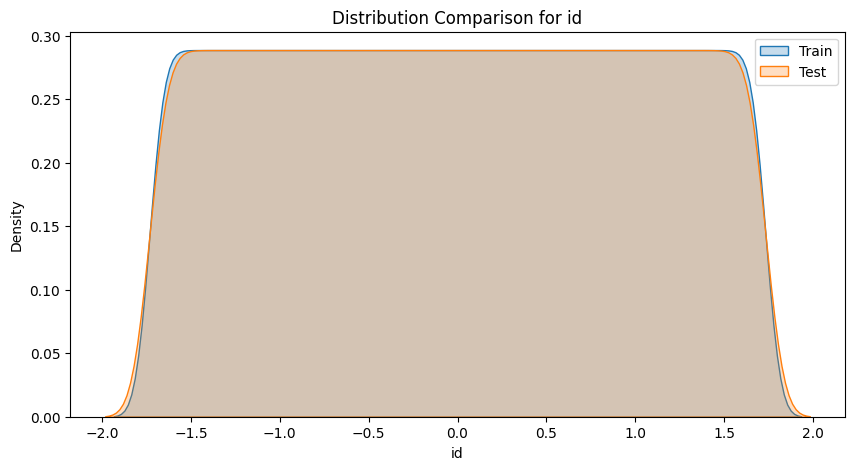

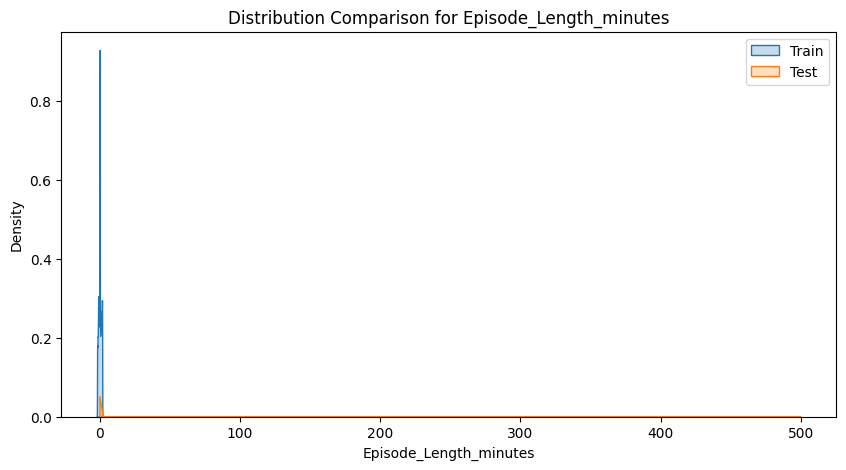

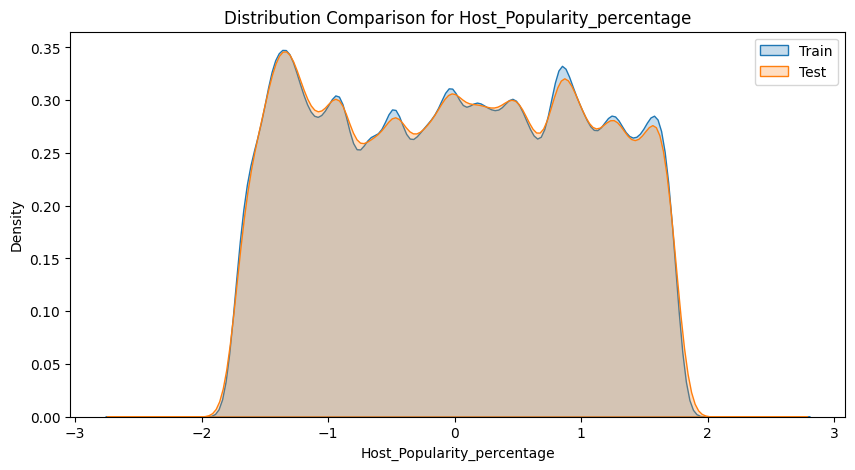

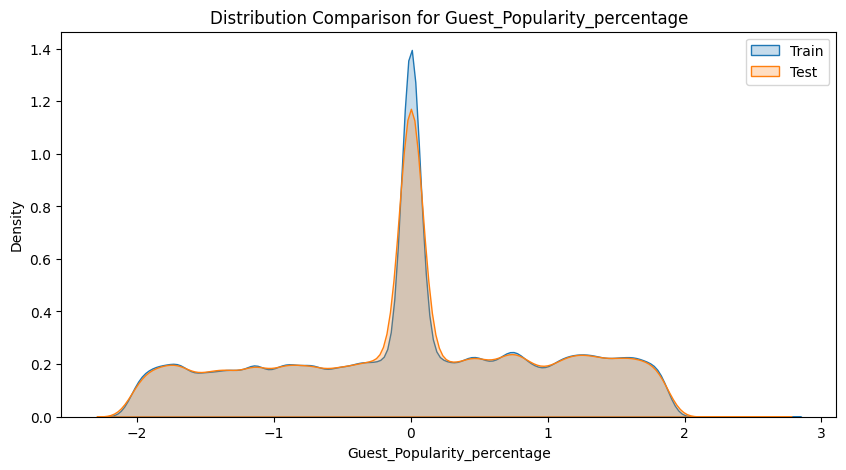

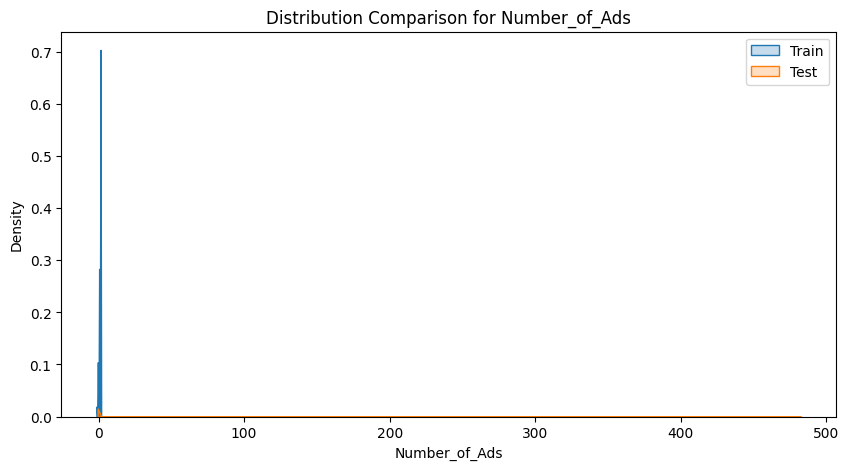

Total outliers removed: 10


In [5]:
def remove_outliers(df, column_names):
    df_filtered = df.copy()
    total_outliers = 0

    for column_name in column_names:
        Q1 = df_filtered[column_name].quantile(0.25)
        Q3 = df_filtered[column_name].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Boolean mask of outliers
        mask_outliers = (df_filtered[column_name] < lower_bound) | (df_filtered[column_name] > upper_bound) # true if outlier
        num_outliers = mask_outliers.sum() # add number of outliers for current column
        total_outliers += num_outliers

        # Remove outliers from df_filtered
        df_filtered = df_filtered[~mask_outliers]

    print(f"Total outliers removed: {total_outliers}")
    return df_filtered
    
def feature_engineer(df):
    # Impute missing values for the columns identified above as having NULL values
    df['Episode_Length_minutes'].fillna(df['Episode_Length_minutes'].mean(), inplace=True)
    df['Guest_Popularity_percentage'].fillna(df['Guest_Popularity_percentage'].mean(), inplace=True)
    df = df.dropna(subset=['Number_of_Ads'])

    # One hot encoding of categoricals
    cat_features = df.select_dtypes(include=['object']).columns
    df = pd.get_dummies(df,columns=cat_features)  

    # Standardize numerical features to get proximal distributions
    numerical_features = df.select_dtypes(include=['float64','int64']).columns.to_list()
    # We don't want to standardize the targets
    if target_column in numerical_features: # fulltrain_df
        numerical_features.remove(target_column) 
        
    std_scaler = StandardScaler()
    for col in numerical_features:
        print(col)
        df[col] = std_scaler.fit_transform(df[[col]])    
    return df
    
# Feature engineer the data
fulltrain_df = feature_engineer(fulltrain_df)
fulltest_df = feature_engineer(fulltest_df)
check_numerical_distribution(fulltrain_df, fulltest_df) # recheck distributions

# Remove outliers from train data
fulltrain_df = remove_outliers(fulltrain_df, fulltrain_df.select_dtypes(include=['float64','int64']).columns.to_list())


# Spit into training and validation sets

In [6]:
fulltrain_X, fulltrain_y = fulltrain_df.drop(columns=[target_column]), fulltrain_df[target_column]

train_X, val_X, train_y, val_y = train_test_split(fulltrain_X, fulltrain_y, test_size=0.15, random_state=42)
print(f'Training set: {train_X.shape}')
print(f'Validation set: {val_X.shape}')

Training set: (637490, 177)
Validation set: (112499, 177)


# Cross Validation


In [7]:
# import xgboost as xgb
# from sklearn.model_selection import GridSearchCV
# from sklearn.datasets import make_regression
# from sklearn.model_selection import train_test_split
# import numpy as np

# # Create the XGBoost Regressor model
# model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# # Define the parameter grid to search over
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 5, 7],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
#     'gamma': [0, 0.1, 0.2],
# }

# # Set up GridSearchCV
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
#                            scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# # Fit the grid search
# grid_search.fit(val_X, val_y)

# # Print the best parameters and best score
# best_parameters = grid_search.best_params_
# print(f"Best Parameters: {best_parameters}")
# print(f"Best Score (MSE): {-grid_search.best_score_}")


# Train and Predict on validation set

In [ ]:
# Initialize and train the model
model = XGBRegressor(n_estimators=500, learning_rate=0.08, max_depth=15, verbose=-1, random_state=42)
model.fit(train_X, train_y)
y_val_pred = model.predict(val_X)
rmse = mean_squared_error(val_y, y_val_pred, squared=False)
print(f'RMSE: {rmse}')

# Generate submissions

In [ ]:
y_test_pred = model.predict(fulltest_df)
df_sub = pd.read_csv('/kaggle/input/playground-series-s5e4/sample_submission.csv')
df_sub[target_column] = y_test_pred
df_sub.to_csv('submission.csv', index=False)

## 